In [55]:
import numpy as np, matplotlib.pyplot as plt, pulp, pandas as pd
from matplotlib import cm
from time import time
from tqdm.notebook import tqdm

In [56]:
np.random.seed(8)

In [57]:
# create functions
n = 10 # number of linear functions
d = 1
# C = np.zeros(shape=(n,d))
# C[0,:] = np.random.uniform(size=d)
# C[1,:] = -np.random.uniform(size=d)
C = np.random.normal(size=(n,d))

b = np.random.normal(size=n)
x0 = np.random.normal(size=d, scale=2)

f = lambda x: np.max(C@x + b)
n_iters = 1000
df_err = pd.DataFrame(columns=('Sub-Grad', 'GRAAL', 'GRAAL (KL)')) # distance between current iterate and actual sol
df_time = pd.DataFrame(columns=('Sub-Grad', 'GRAAL', 'GRAAL (KL)')) # time at current iterate

In [58]:
# solve with LP first
prob = pulp.LpProblem('Linear', pulp.LpMinimize)

# variables
t = pulp.LpVariable('Auxiliary')
x = [pulp.LpVariable(f'x_{i}') for i in range(d)]

# objective
prob += t

# constraints
for i in range(n):
    prob += t >= pulp.LpAffineExpression(zip(x,C[i,:]))  + b[i]

prob.solve(pulp.GUROBI())

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 10 rows, 2 columns and 20 nonzeros
Model fingerprint: 0xc5549530
Coefficient statistics:
  Matrix range     [9e-02, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 2e+00]
Presolve removed 10 rows and 2 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1771790e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.177178982e+00
Gurobi status= 2


1

In [59]:
sol = np.array([xi.varValue for xi in x])
obj = prob.objective.value()
assert(np.isclose(obj, f(sol)))
sol

array([-0.67735391])

  0%|          | 0/10 [00:00<?, ?it/s]

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

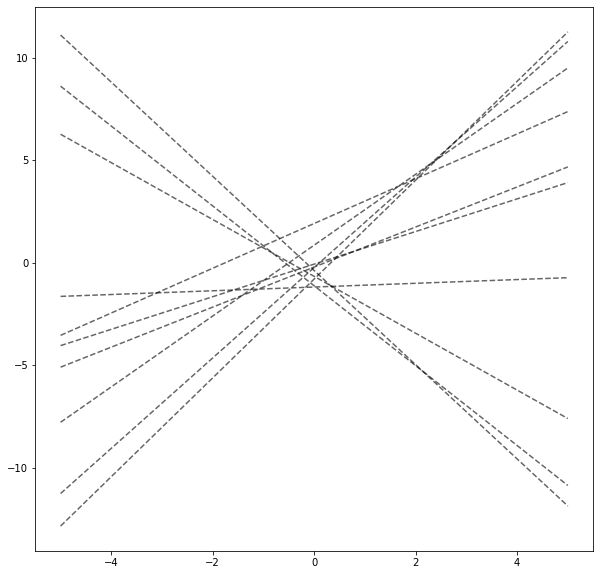

In [60]:
# plot objective function (for d=1)
fig = plt.figure(figsize=(10,10))
X = np.linspace(-5,5,250)

for i in tqdm(range(n)):
    fi_v = np.vectorize(lambda x: C[i]*x + b[i])
    Y = fi_v(X)
    plt.plot(X,Y,'k--', alpha=.6)

f_v = np.vectorize(f)
Y = f_v(X)
plt.plot(X, Y, 'k-')
plt.plot(sol, f(sol), 'r.', markersize=14)
plt.show()

In [61]:
# sub gradient

x = x0
time0 = time()
gamma = lambda k: 1/(10+k)
fi = lambda x,i: C[i,:]@x + b[i]

for k in tqdm(range(n_iters)):
    gamma = 1/(10+k)
    fval = f(x)
    G = np.array([C[i,:] for i in range(n) if np.isclose(fi(x, i), fval)])
    g = G.mean(axis=0)
    
    if (g == 0).all(): # solution reached
        df_err.loc[k:, 'Sub-Grad'] = 0
        df_time.loc[k:, 'Sub-Grad'] = time()-time0
        break
        
    x, x1 = x - gamma*g/np.linalg.norm(g), x
    df_err.loc[k, 'Sub-Grad'] = np.linalg.norm(f(x)-obj) 
    df_time.loc[k, 'Sub-Grad'] = time()-time0

  0%|          | 0/1000 [00:00<?, ?it/s]

In [62]:
# GRAAL 

x = x0
y = np.ones(shape=n)/n
z = np.array([*x, *y])
x_ = x + np.random.uniform(size=d)
z_ = np.array([*x_, *y])
time0 = time()
phi = (1 + np.sqrt(5))/2

F = lambda z: np.array([*(z[-n:]@C), *(-C@z[:-n]-b)])

L = np.linalg.norm(C)
lam = phi/(2*L)
k = 0

def sim_proj(z, la=None):
    # projection of y component onto simplex. scalar and x var ignored
    x, y = z[:-n], z[-n:]
    u = sorted(y, reverse=True)
    rho = max(
        j for j in range(n)
        if u[j] + (1/(j+1))*(1 - sum(u[:j+1])) > 0
    )
    la = (1/(rho+1))*(1 - sum(u[:rho+1]))
    
    for i in range(n): y[i] = max(y[i] + la, 0)
    
    return np.array([*x, *y])

for k in tqdm(range(n_iters)):
    z_ = ((phi-1)*z + z_)/phi
    z = sim_proj(z_ - lam*F(z))
    x = z[:-n]
#     err = np.linalg.norm(f(x) - f(x1))
    df_err.loc[k, 'GRAAL'] = np.linalg.norm(f(x)-obj) 
    df_time.loc[k, 'GRAAL'] = time()-time0
    
sol_x, sol_y = z[:-n], z[-n:]    

  0%|          | 0/1000 [00:00<?, ?it/s]

In [63]:
# GRAAL (KL)
df = pd.DataFrame(columns=['D(y{k+1}, y_{k+1})',
                           'D(y{k+1}, y_k)',
                           'D(yk, y_k)'])

x = x0
y = np.ones(shape=n)/n
z = np.array([*x, *y])
x_ = x + np.random.uniform(size=d)
z_ = np.array([*x_, *y])
time0 = time()
phi = (1 + np.sqrt(5))/2

F = lambda z: np.array([*(z[-n:]@C), *(-C@z[:-n]-b)])
h = lambda y: np.sum([y[i]*np.log(y[i]) for i in np.where(y!=0)])
g_h = lambda y: np.array([np.log(yi) + 1 if yi > 0 else -np.inf for yi in y])
g_h_inv = lambda y: np.exp(y-1)    
D = lambda x,y: h(x) - h(y) - np.dot(g_h(y), x-y)

L = np.linalg.norm(C)
lam = phi/(2*L)
k = 0

def step(z, z_, F, la):
    # complete step of algorithm
    x, y = z[:-n], z[-n:]
    x_, y_ = z_[:-n], z_[-n:]
    Fx, Fy = F[:-n], F[-n:]
    
    x_ = ((phi-1)*x + x_)/phi
    x = x_ - la*Fx
    
    y_ = g_h_inv(((phi-1)*g_h(y) + g_h(y_))/phi)
    u = g_h_inv(g_h(y_) - la*Fy) # intermediate projection step
    y = u/np.linalg.norm(u, ord=1)
    
    z = np.array([*x, *y])
    z_ = np.array([*x_, *y_])
    return z, z_

for k in tqdm(range(n_iters)):
    (z, z_), (z1, z1_) = step(z, z_, F(z), lam), (z, z_)
    x = z[:-n]
    df_err.loc[k, 'GRAAL (KL)'] = f(x)-obj 
    df_time.loc[k, 'GRAAL (KL)'] = time()-time0
    
    y, y_, y1, y1_ = z[-n:], z_[-n:], z1[-n:], z1_[-n:]
    x, x_, x1, x1_ = z[:-n], z_[:-n], z1[:-n], z1_[:-n]
    df.loc[k, 'D(y{k+1}, y_{k+1})'] = D(y, y_) + .5*np.linalg.norm(x - x_)
    df.loc[k, 'D(y{k+1}, y_k)'] = D(y, y1_) + .5*np.linalg.norm(x - x1_)
    df.loc[k, 'D(yk, y_k)'] = D(y1, y1_) + .5*np.linalg.norm(x1 - x1_)
    df.loc[k, 'Energy'] = (1+phi)*(D(sol_y,y_)+.5*np.linalg.norm(sol_x-x_)**2) + (phi/2)*(D(y,y1)+.5*np.linalg.norm(x-x1)**2)

  0%|          | 0/1000 [00:00<?, ?it/s]

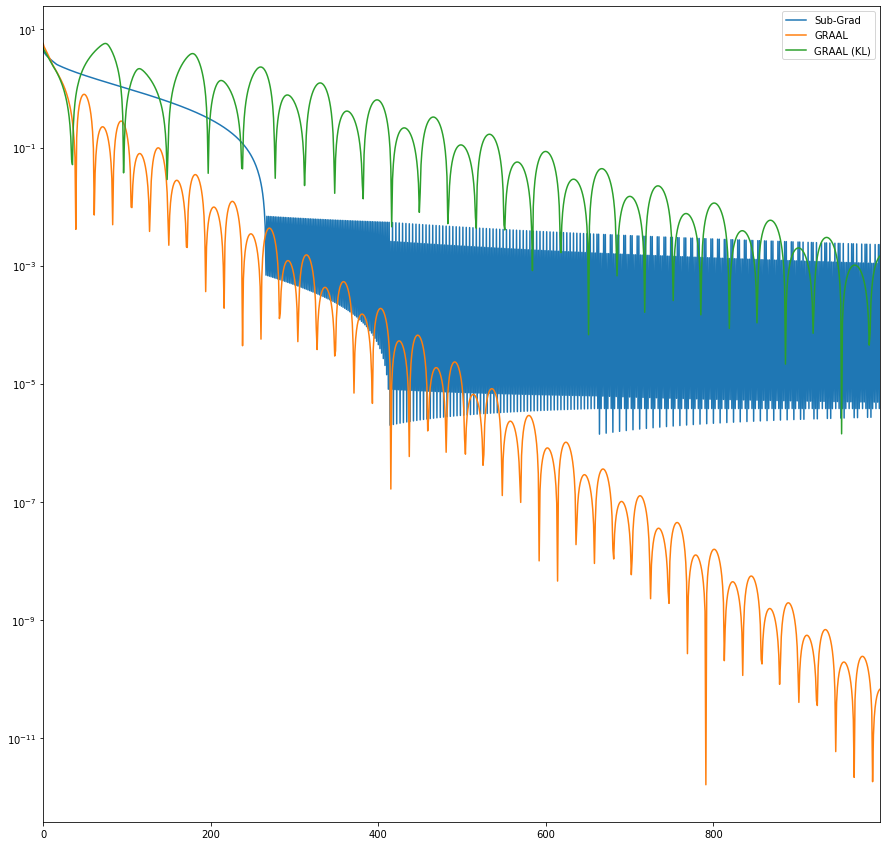

In [64]:
fig, ax = plt.subplots(figsize=(15,15))
df_err.plot(ax=ax, logy=True)
plt.show()

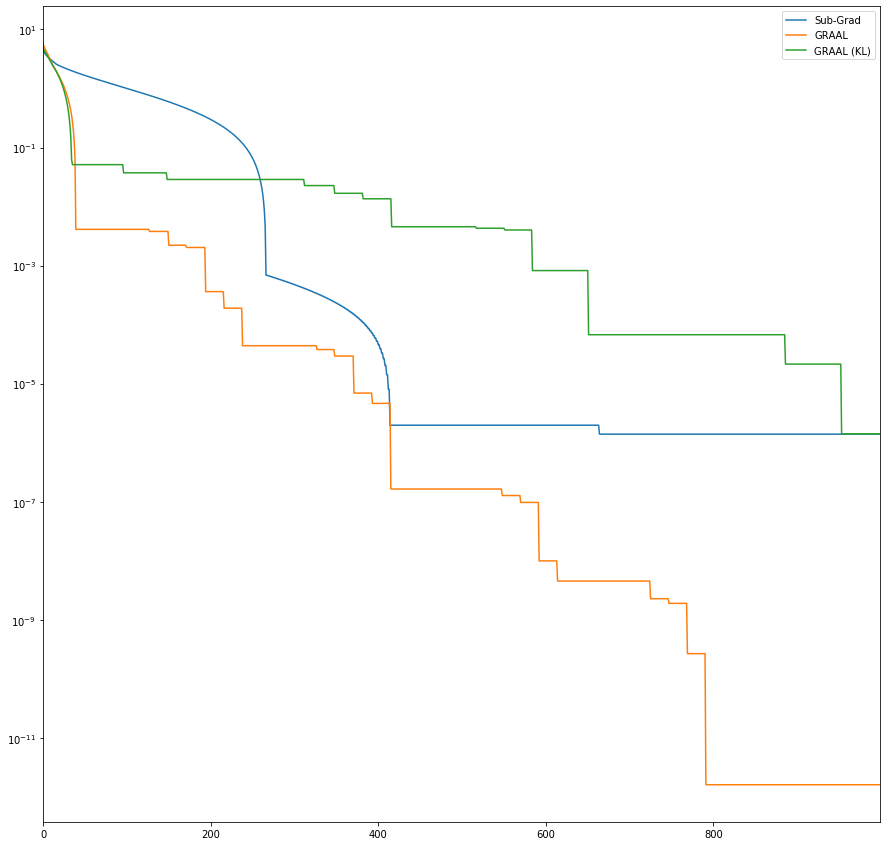

In [65]:
df_min_err = df_err.apply(lambda col: [min(col.loc[:i]) for i in range(n_iters)])

fig, ax = plt.subplots(figsize=(15,15))
df_min_err.plot(ax=ax,logy=True)
#fig.savefig('err.png')
plt.show()

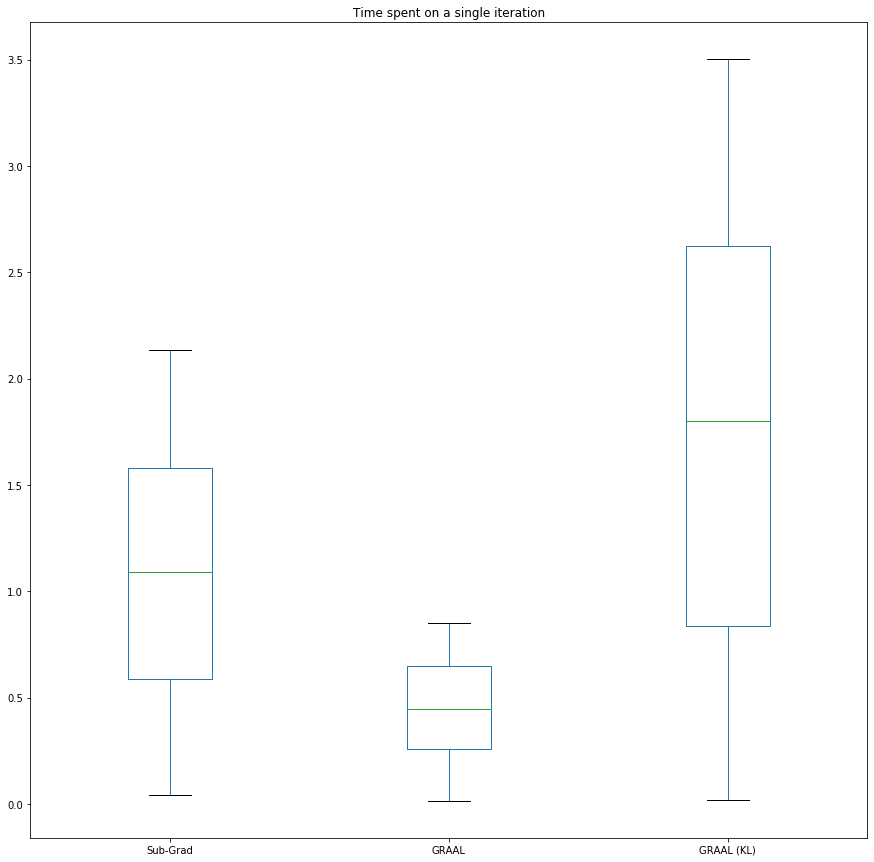

In [66]:
df_time.plot.box(figsize=(15,15), title='Time spent on a single iteration')
plt.show()

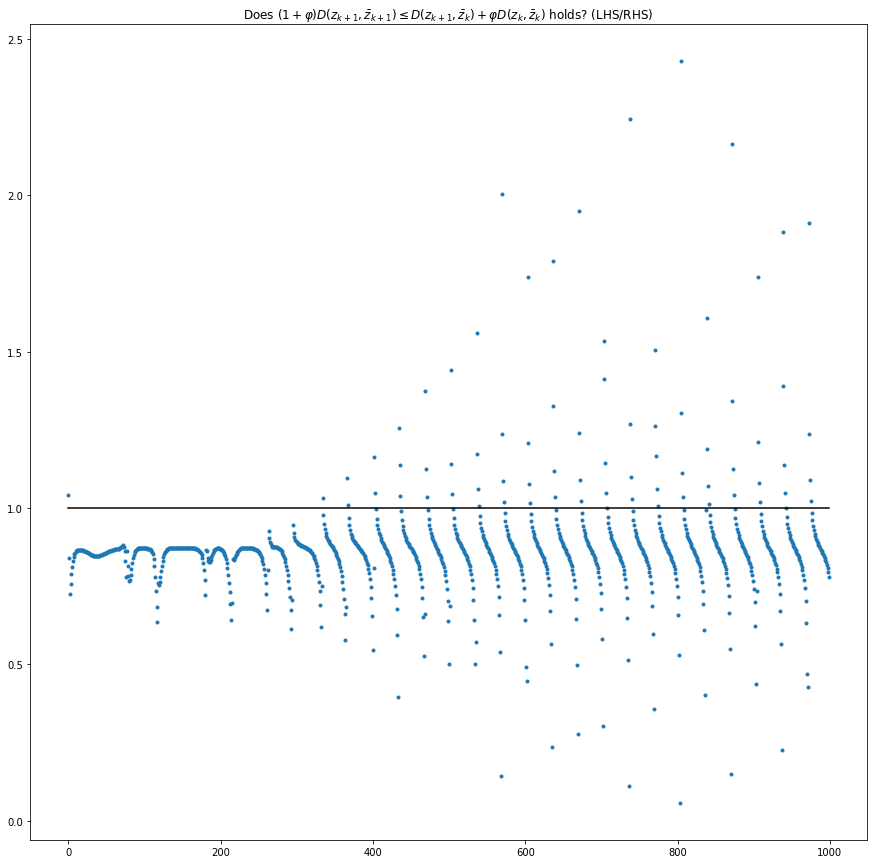

(array([  0, 334, 366, 367, 402, 403, 434, 435, 436, 469, 470, 471, 502,
        503, 504, 536, 537, 538, 539, 569, 570, 571, 572, 603, 604, 605,
        606, 636, 637, 638, 639, 670, 671, 672, 673, 703, 704, 705, 706,
        707, 737, 738, 739, 740, 770, 771, 772, 773, 774, 804, 805, 806,
        807, 838, 839, 840, 841, 871, 872, 873, 874, 905, 906, 907, 908,
        938, 939, 940, 941, 942, 972, 973, 974, 975]),)

In [67]:
fig,ax = plt.subplots(figsize=(15,15))

LHS = (phi+1)*df['D(y{k+1}, y_{k+1})']
# ax.plot(Y, 'y-', label='LHS')

RHS = df['D(y{k+1}, y_k)'] + phi*df['D(yk, y_k)']
# ax.plot(Y, 'g-', label='RHS')
ax.plot(LHS/RHS, '.')

X = df.index
Y = [1]*len(X)
ax.plot(X, Y, 'k-')

plt.title(r"Does $(1+\varphi)D(z_{k+1}, \bar{z}_{k+1}) \leq D(z_{k+1}, \bar{z}_k) + \varphi D(z_k, \bar{z}_k)$ holds? (LHS/RHS)")
plt.show()

np.where(LHS > RHS)

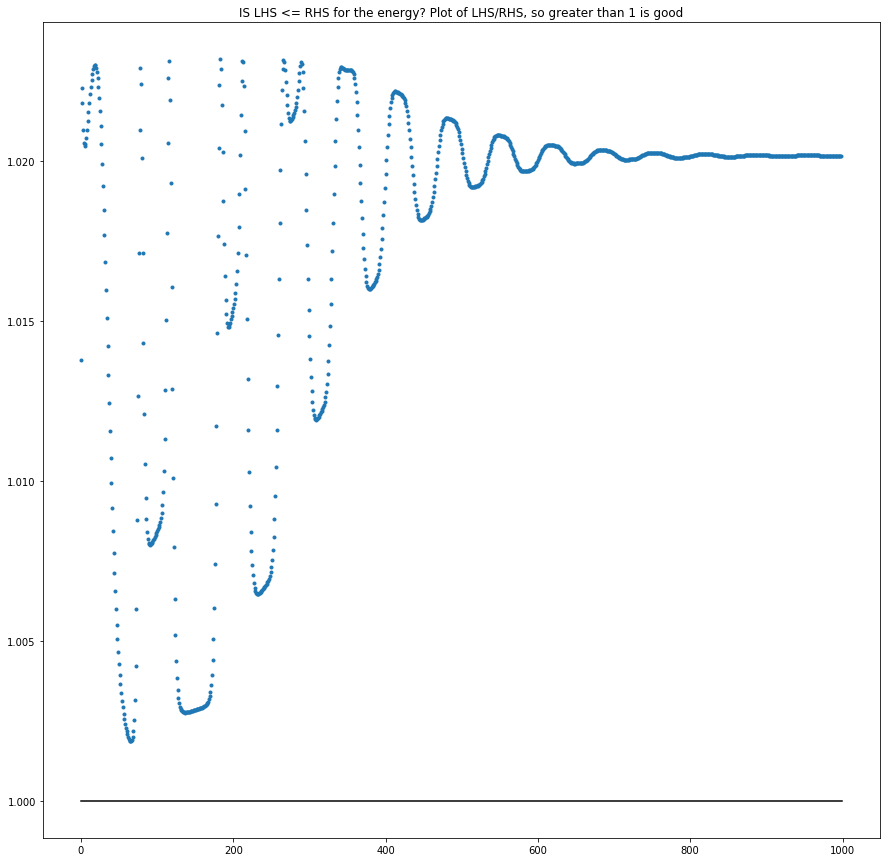

In [68]:
fig2,ax2 = plt.subplots(figsize=(15,15))

LHS = df['Energy']
LHS = LHS[:-1].reset_index()
LHS = LHS['Energy']

# ax.plot(Y, 'y-', label='LHS')

RHS = df['Energy']
RHS = RHS[1:].reset_index()
RHS = RHS['Energy']

# ax.plot(Y, 'g-', label='RHS')
ax2.plot(LHS/RHS,".")

X = df.index
Y = [1]*len(X)
ax2.plot(X, Y, 'k-')

plt.title("IS LHS <= RHS for the energy? Plot of LHS/RHS, so greater than 1 is good")
plt.show()

#np.where(LHS > RHS)

MKT: The plot